# Weather Data Analysis Project

## Objective
The goal of this project is to analyze a decade of weather data for Lisbon, uncovering climate patterns and establishing a foundation for extended climate studies.

## Data Source
The dataset used in this project is sourced from NOAA's National Centers for Environmental Information. It specifically focuses on the Lisbon Geofisica station, identified by:

    Station ID: PO000008535
    Location: LISBOA GEOFISICA, PO
    Latitude: 38.7167
    Longitude: -9.15
    Elevation: 77 meters above sea level

This data includes daily measurements of precipitation, snow depth, and temperatures (maximum, minimum, and average) spanning from January 1st, 2010 to December 31st, 2020.

## Specific Goals
- Compare inter-annual temperature variations.
- Analyze precipitation trends to see how they have evolved over time.
- Check for significant changes in weather patterns, such as variations in seasonal lengths or extreme weather events.

## Tools & Libraries

### Data Processing and Analysis:

- **Pandas**: For data manipulation and analysis. Used for data cleaning, preparation, and statistical analysis.
- **NumPy**: Provides support for array-based operations and mathematical functions.

#### Statistical Analysis:

- **SciPy**: Used for the Mann-Whitney U Test, a non-parametric test to compare two independent samples.
- **PyMannKendall**: A library for performing the Mann-Kendall Trend Test to detect trends in the dataset.

#### Time Series Analysis:

- **Statsmodels**: Employed for advanced statistical models. Used for:
- **Seasonal Decompose**: To decompose time-series data into trend, seasonal, and residual components.
- **ADF (Augmented Dickey-Fuller) Test**: To check the stationarity of the time-series data.

#### Data Visualization:

- **Matplotlib**: A plotting library for creating static, animated, and interactive visualizations in Python.
- **Seaborn**: Based on Matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.
    
## Key Findings

- The dataset's stationarity points to a decade without pronounced climate trends in Lisbon, as indicated by the Dickey-Fuller Test (p-value: 0.001019).
- The Mann-Kendall and Mann-Whitney U tests corroborate a stable climate with no significant changes in temperature or precipitation during the 2010s.
- The visual analysis reveals regular seasonal cycles and a lack of long-term shifts, suggesting a relatively stable climate for the decade.

## Implications

The analysis implies a stable Lisbon climate over the studied decade. However, considering global climate trends, extended research across multiple decades is essential for a more comprehensive understanding.

## Future Research 

For a comprehensive understanding of Lisbon's climate, it's recommended to extend the dataset to cover multiple decades, enabling the detection of long-term climate trends. Advanced statistical models should be employed to identify subtle shifts in climate patterns. Additionally, investigating extreme weather events will provide deeper insights into climate variability. To put these findings into a global context, regional comparative studies are essential to understand how localized climate impacts fit within broader climatic changes.


#### This project will walk through data cleaning, exploratory data analysis, time-series analysis, and result in visualizations that highlight the key findings

---

### 1. Load the Data

In [1]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import mannwhitneyu
import pymannkendall as mk

In [3]:
# Load the dataset
data = pd.read_csv(r'C:\Users\Sarah\Documents\Jupyter Notebook\lisbon_weather.csv', parse_dates=['DATE'])

# Show the first few lines of the dataframe
data.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
0,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-01,3.1,",,E",NaN,NaN,NaN,NaN,16.2,",,E",9.9,",,E"
1,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-02,0.5,",,E",NaN,NaN,NaN,NaN,14.0,",,E",9.9,",,E"
2,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-03,24.5,",,E",NaN,NaN,NaN,NaN,15.7,",,E",12.4,",,E"
3,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-04,22.5,",,E",NaN,NaN,13.0,"H,,S",16.2,",,E",11.0,",,E"
4,PO000008535,"LISBOA GEOFISICA, PO",38.7167,-9.15,77,2010-01-05,0.0,",,E",NaN,NaN,12.3,"H,,S",14.9,",,E",10.9,",,E"


### 2. Data Cleaning and Preparation

In [4]:
# Initial assessment of missing values
missing_values = data.isnull().sum()
print(missing_values)

# Data Cleaning
# Drop 'ATTRIBUTES' columns, 'SNWD', and station information columns
cols_to_drop = [col for col in data.columns if 'ATTRIBUTES' in col] + ['SNWD', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
data_cleaned = data.drop(columns=cols_to_drop)

# Ensure 'DATE' is of datetime type
data_cleaned['DATE'] = pd.to_datetime(data_cleaned['DATE'])

# Convert temperature and precipitation columns to numeric types, coercing errors to NaN
data_cleaned['TMAX'] = pd.to_numeric(data_cleaned['TMAX'], errors='coerce')
data_cleaned['TMIN'] = pd.to_numeric(data_cleaned['TMIN'], errors='coerce')
data_cleaned['PRCP'] = pd.to_numeric(data_cleaned['PRCP'], errors='coerce')

# Interpolate missing TMAX and TMIN values
data_cleaned['TMAX'] = data_cleaned['TMAX'].interpolate()
data_cleaned['TMIN'] = data_cleaned['TMIN'].interpolate()

# Recalculate the TAVG based on the interpolated TMAX and TMIN
data_cleaned['TAVG'] = (data_cleaned['TMAX'] + data_cleaned['TMIN']) / 2

# Remove duplicates, abnormal values, and outliers
data_cleaned = data_cleaned.drop_duplicates()
data_cleaned = data_cleaned[
    (data_cleaned['TMAX'] <= 50) &
    (data_cleaned['TMIN'] >= -10) &
    (data_cleaned['TAVG'] <= 40) &
    (data_cleaned['TAVG'] >= -10) &
    (data_cleaned['PRCP'] >= 0) &
    (data_cleaned['PRCP'] <= 500)
]

# Limit the analysis to data up to January 1st, 2020
data_cleaned = data_cleaned[data_cleaned['DATE'] < '2020-01-01']

# Check for missing values after all cleaning operations
print("Missing values after all cleaning operations:")
print(data_cleaned.isnull().sum())
print("\nData types and non-null counts after all cleaning operations:")
print(data_cleaned.info())

# Display the cleaned data
print("\nCleaned data preview:")
print(data_cleaned.head())

STATION               0
NAME                  0
LATITUDE              0
LONGITUDE             0
ELEVATION             0
DATE                  0
PRCP                213
PRCP_ATTRIBUTES     213
SNWD               3960
SNWD_ATTRIBUTES    3960
TAVG                345
TAVG_ATTRIBUTES     345
TMAX                284
TMAX_ATTRIBUTES     284
TMIN                128
TMIN_ATTRIBUTES     128
dtype: int64
Missing values after all cleaning operations:
DATE    0
PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

Data types and non-null counts after all cleaning operations:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3644 entries, 0 to 3651
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3644 non-null   datetime64[ns]
 1   PRCP    3644 non-null   float64       
 2   TAVG    3644 non-null   float64       
 3   TMAX    3644 non-null   float64       
 4   TMIN    3644 non-null   float64       
dtypes: datetime6

## Data Cleaning and Preparation Summary 

The dataset, containing weather data for Lisbon, Portugal, was loaded into a pandas DataFrame with special attention to correctly parsing dates. The initial exploration involved understanding the data's structure through basic methods like `data.head()`.

#### The data cleaning process involved:

- **Column Removal**: Dropped unnecessary columns and attributes.
- **Type Conversion**: Ensured correct data types for DATE, temperatures, and precipitation.
- **Interpolation**: Filled missing temperature data for continuity.
- **Data Quality**: Removed duplicates and outliners for cleaner data.
- **Date Limitation**: Confined analysis to data before January 1st, 2020.

### Methodological Rationale for Data Exclusion

Upon rigorous initial data assessment, it was observed that the dataset for the year 2020 was marred by a significant amount of missing entries. Given the extent and the non-random distribution of these gaps, traditional imputation methods, including those leveraging machine learning, were deemed unsuitable. Such techniques, while potent for random and sparse occurrences of missing data, are less reliable when the missingness exhibits a systematic pattern or constitutes a large fraction of the data, as was the case for the year 2020. The risk of imputation in this scenario is the introduction of bias, which could manifest as artificial trends or distortions in variability.

Statistically, the integrity of the time series analysis is contingent upon the continuity and completeness of data. The imputation of a substantial portion of a time series could inadvertently result in spurious correlations or misleading inferences about trends. Moreover, the extrapolation of data through imputation into a period where the data is predominantly missing fails to meet the necessary assumptions for most imputation techniques, which typically presume randomness in the distribution of missing points.

Therefore, in the interest of maintaining the veracity of the analytical outcomes, the dataset was truncated to exclude the year 2020, restricting the analysis to a decade of complete data from January 1, 2010, to January 1, 2020. This strategic limitation aligns with best practices for data integrity and reliability in time series analysis, ensuring that the resulting insights are reflective of the true underlying climatological phenomena, free from the potential biases introduced by imputation. This decision underscores a commitment to a methodologically sound approach to the exploration and interpretation of environmental data trends.

#### The dataset is now preprocessed and primed for exploratory data analysis (EDA), providing a solid foundation for reliable insights and modeling.

---

### 3.  Exploratory Data Analysis (EDA)

#### 3.1 Statistical Summary

In [5]:
summary_stats = data_cleaned.describe()
print(summary_stats)

              PRCP         TAVG         TMAX         TMIN
count  3644.000000  3644.000000  3644.000000  3644.000000
mean      2.257382    17.686690    21.556970    13.816411
std       7.126099     4.922367     5.803189     4.281128
min       0.000000     5.350000     7.800000     2.400000
25%       0.000000    13.600000    16.700000    10.400000
50%       0.000000    17.400000    21.000000    13.850000
75%       0.200000    21.650000    26.000000    17.300000
max      91.400000    35.050000    42.000000    29.000000


### Key Insights from Summary Statistics

The summary statistics of Lisbon's weather data highlight a climate characterized by mild temperatures and relatively low precipitation. The average temperature (TAVG) stands at 17.69°C, which underlines a temperate climate. This is further emphasized by the average maximum temperature (TMAX) at around 21.56°C, suggesting warm but not excessively hot summers, and the average minimum temperature (TMIN) at about 13.82°C, indicating mild winters. The standard deviations for these temperature measurements are relatively small, pointing to a stable climate with minimal drastic temperature fluctuations.

In terms of precipitation, the data reveals an intriguing pattern. The average precipitation (PRCP) is about 2.26 mm, suggesting a relatively dry climate. This low average, coupled with a standard deviation that indicates some variability, suggests that while heavy precipitation is uncommon, it's not entirely absent. The maximum recorded precipitation is significantly higher at 91.4 mm, which might indicate occasional heavy rainfall events.

### Analytical Perspectives

From an analytical viewpoint, this updated data provides vital insights into the climatic tendencies of Lisbon. The consistent temperature patterns are crucial for sectors such as agriculture, tourism, and urban planning, providing a predictable environment for these activities. The precipitation data, with its low average and occasional spikes, might be significant for understanding water resource management and planning for rare but potentially intense rainfall events. This climate profile is also essential for assessing seasonal impacts on various aspects of city life and the natural ecosystem, and for anticipating challenges related to global climate change.

Overall, these statistics offer a more nuanced understanding of Lisbon's climate, highlighting its primary characteristics and setting a foundation for more detailed climatic analysis and environmental studies.

---

#### 3.2 Visualize Temperature and Precipitation Trends Over Time

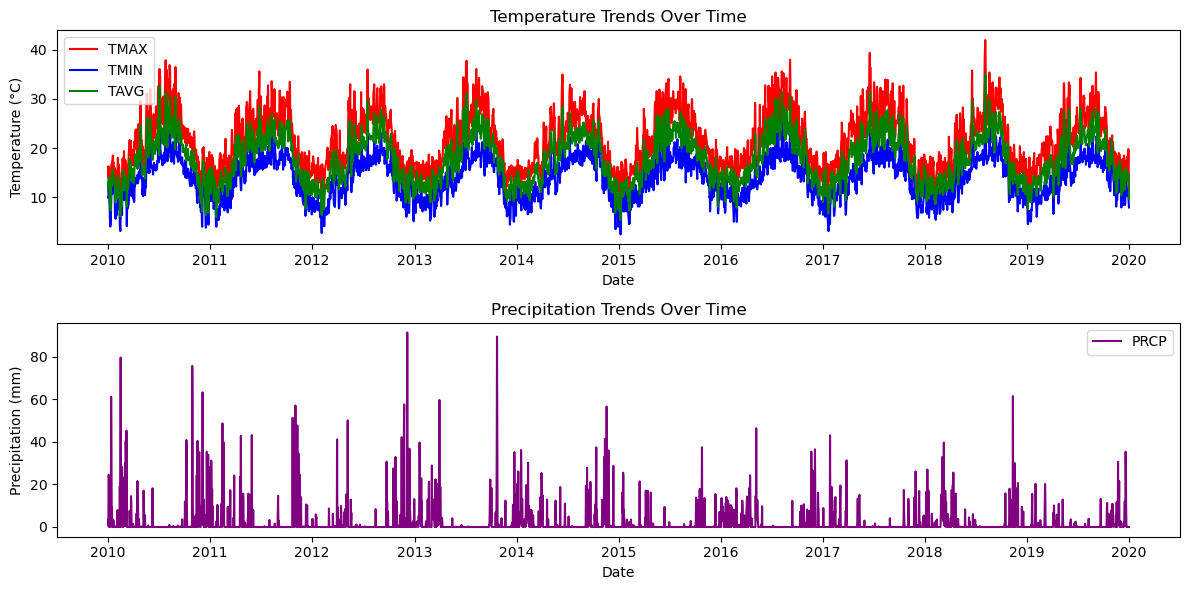

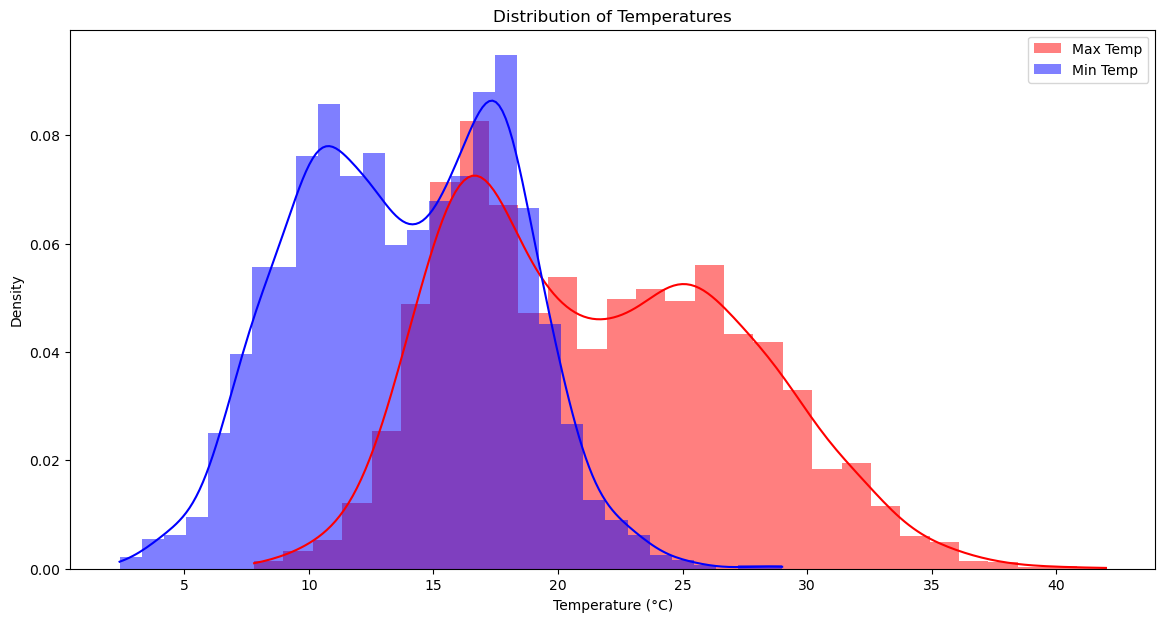

In [6]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data_cleaned['DATE'], data_cleaned['TMAX'], label='TMAX', color='red')
plt.plot(data_cleaned['DATE'], data_cleaned['TMIN'], label='TMIN', color='blue')
plt.plot(data_cleaned['DATE'], data_cleaned['TAVG'], label='TAVG', color='green')
plt.title('Temperature Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data_cleaned['DATE'], data_cleaned['PRCP'], label='PRCP', color='purple')
plt.title('Precipitation Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
sns.histplot(data_cleaned['TMAX'], color='red', label='Max Temp', kde=True, stat="density", linewidth=0)
sns.histplot(data_cleaned['TMIN'], color='blue', label='Min Temp', kde=True, stat="density", linewidth=0)
plt.title('Distribution of Temperatures')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.legend()
plt.show()

### Analysis of Climatic Variability and Extremes in Lisbon

The examination of temperature and precipitation patterns in Lisbon over a decade unveils a clear cyclical behavior in temperature and an irregular distribution in rainfall. The temperature data, encompassing TMAX, TAVG, and TMIN, underscores the city's seasonal rhythm, with the highest temperatures typically occurring in the middle of the year, during summer, and the lowest at the beginning and end of the year, in winter. The TAVG trend, nestled between the highs and lows, smoothens out the extremes, presenting an integrated view of Lisbon's thermal shifts.

In contrast, the precipitation data, denoted by PRCP, exhibits a more sporadic nature, lacking a distinct seasonal trend but marked by notable peaks that could be associated with particular meteorological events. These irregularities in precipitation, along with any aberrations in temperature data, might indicate exceptional weather phenomena, inviting further analysis to decipher their impact on broader climatic trends.

The temperature distribution, articulated through histograms and density curves, elucidates the distribution and prevalence of temperature values within their respective ranges. This visual exploration delineates the boundaries between maximum and minimum temperature occurrences and their density across different temperature bands.

These detailed visual representations enable us to decode Lisbon's climate narrative, offering invaluable insights for environmental management, agricultural scheduling, and the formulation of responsive measures to the challenges posed by climate variability and change.

---

#### 3.3 Investigate Seasonal Patterns

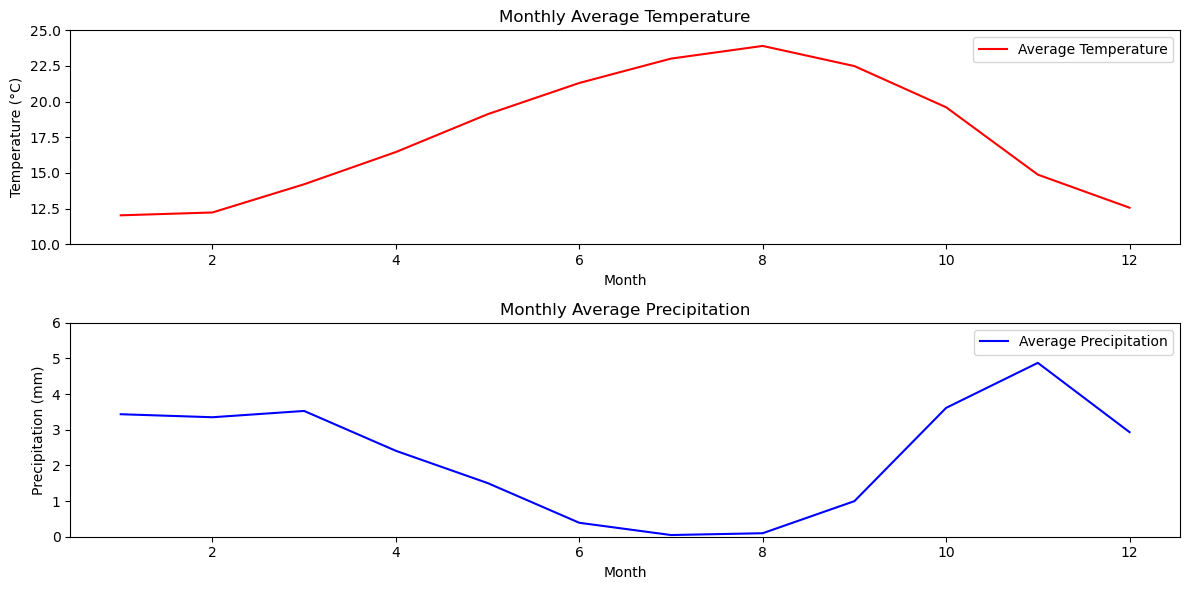

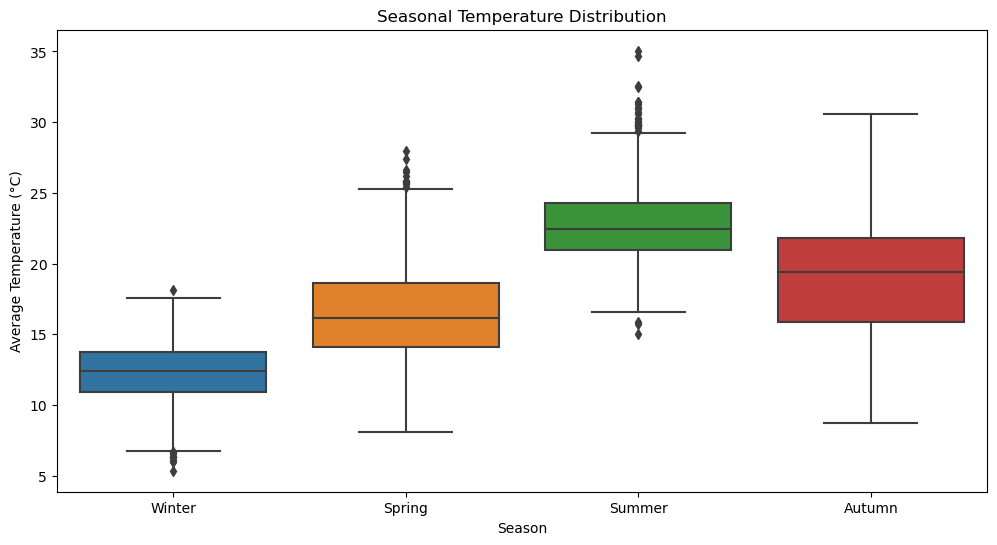

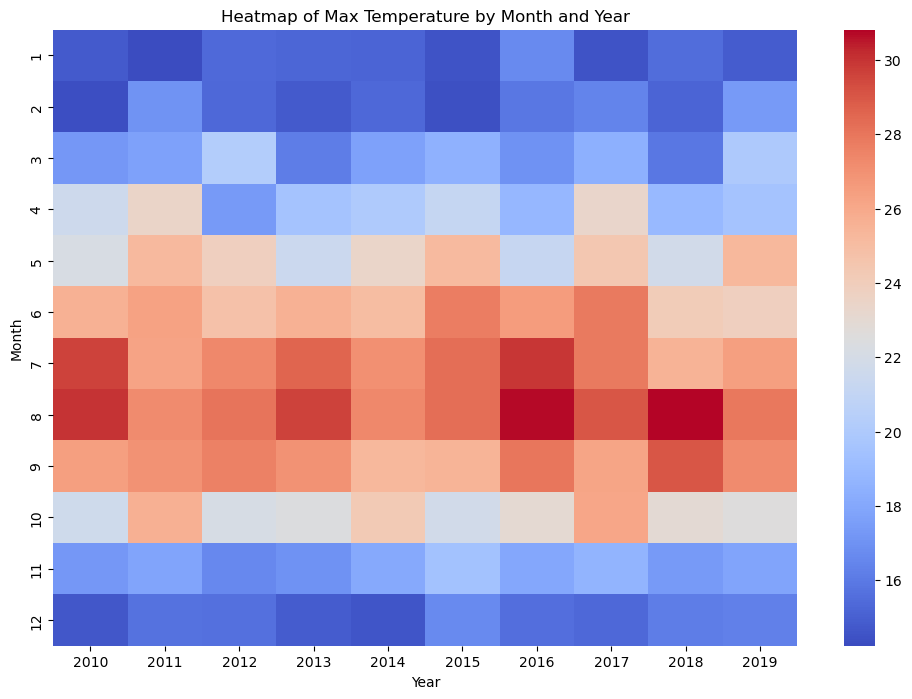

In [7]:
monthly_avg = data_cleaned.groupby(data_cleaned['DATE'].dt.month).mean()

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(monthly_avg['TAVG'], label='Average Temperature', color='red')
plt.title('Monthly Average Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.ylim([10, 25])  

plt.subplot(2, 1, 2)
plt.plot(monthly_avg['PRCP'], label='Average Precipitation', color='blue')
plt.title('Monthly Average Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.ylim([0, 6])  

plt.tight_layout()
plt.show()


seasons = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 
    11: 'Autumn', 12: 'Winter'
}
data_cleaned['Season'] = data_cleaned['DATE'].dt.month.map(seasons)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Season', y='TAVG', data=data_cleaned)
plt.title('Seasonal Temperature Distribution')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.show()

heatmap_data = data_cleaned.pivot_table(values='TMAX', index=data_cleaned['DATE'].dt.month, columns=data_cleaned['DATE'].dt.year)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm')
plt.title('Heatmap of Max Temperature by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


### Understanding Seasonal Patterns and Outliers in Lisbon's Climate

A comprehensive review of Lisbon’s climatic data over a decade reveals a profound connection between the seasons and temperature variations, alongside the occurrence of precipitation. The monthly average temperature graph illustrates a typical pattern of seasonal change, with temperatures peaking during the summer months and reaching their lowest in winter, reflecting the city’s Mediterranean climate characteristics.

The monthly average precipitation chart complements this temperature profile by indicating a less consistent but noticeable pattern, where rainfall peaks can occur in both autumn and spring, suggesting a variance in precipitation that does not strictly align with temperature highs and lows. This dual representation underlines the complex interplay between temperature and rainfall in defining seasonal weather.

Seasonal temperature distribution, as detailed by the box plots, offers a more granular view of the data. It not only captures the central tendency and dispersion of temperatures across seasons but also highlights outliers that might correspond to unexpected weather events. Such deviations underscore the presence of atypical climatic behavior within the overarching seasonal framework.

The heatmap further enhances our understanding by mapping out the maximum temperatures across months and years, providing a visual representation of the heat intensity. This plot allows for the observation of both the annual thermal rhythm and the occasional anomalous months that break the regular pattern, which could be indicative of broader environmental changes.

Collectively, these visualizations paint a detailed picture of Lisbon's climate, showcasing the rhythm of the seasons and the occasional aberrations that may signal shifting climatic trends. This information is invaluable, providing a foundation for further research into climate dynamics and informing adaptive strategies for regional planning and policy-making in response to climatic variability.

---

#### 3.4 Explore Relationships Between Variables

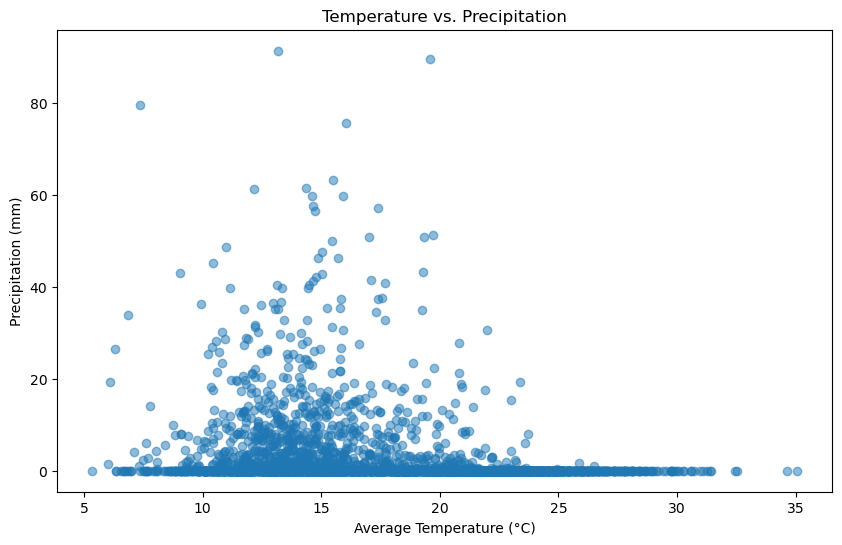

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(data_cleaned['TAVG'], data_cleaned['PRCP'], alpha=0.5)
plt.title('Temperature vs. Precipitation')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.show()

### Correlation Analysis between Temperature and Precipitation in Lisbon

The scatter plot provided illustrates the relationship between average temperature and precipitation in Lisbon over a period spanning from 2010 to 2019. Each data point on the plot corresponds to a combination of average temperature (x-axis) and recorded precipitation (y-axis) for a given time interval.

The visual representation of the data points shows a noticeable concentration at the lower spectrum of precipitation, which is prevalent across various temperatures. This pattern indicates that drier days are more common in Lisbon, occurring throughout a broad temperature range. As precipitation levels rise, the data points become sparser, signaling that high rainfall events are less frequent.

The plot does not display a distinct directional trend that would suggest a strong correlation between temperature and the amount of rainfall. In many climates, one might expect to see a discernible pattern, such as a diagonal line indicating that higher temperatures are associated with lower precipitation levels, or the opposite. The absence of such a trend here implies that Lisbon's temperature and precipitation may not be directly or linearly related.

This observation could be the result of Lisbon’s unique climatic conditions, geographic influences, or the interplay of different seasonal weather systems. For example, substantial rainfall might occur during periods of both cooler and warmer temperatures, reflecting the diverse climatic events characteristic of the region.

To gain quantitative insights into the relationship between temperature and precipitation, a more detailed statistical analysis would be necessary. However, this scatter plot serves as a preliminary step in identifying potential patterns or highlighting areas for further investigation. It also demonstrates the intricate nature of climatic interactions, where simple visual assessments may not capture the underlying complexities of environmental factors at play.

---

#### 3.5 Temporal Dynamics and Predictability in Temperature Patterns

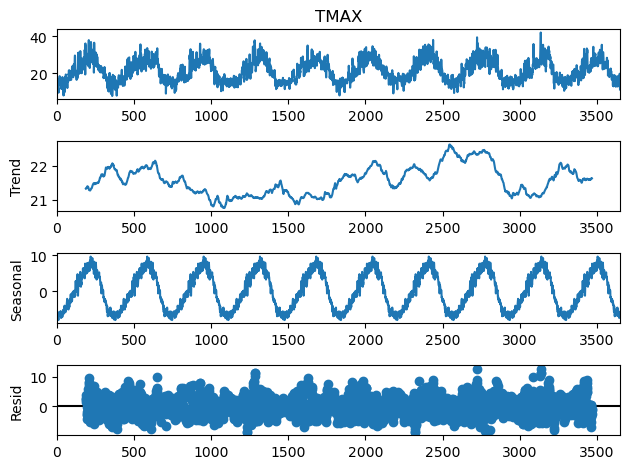

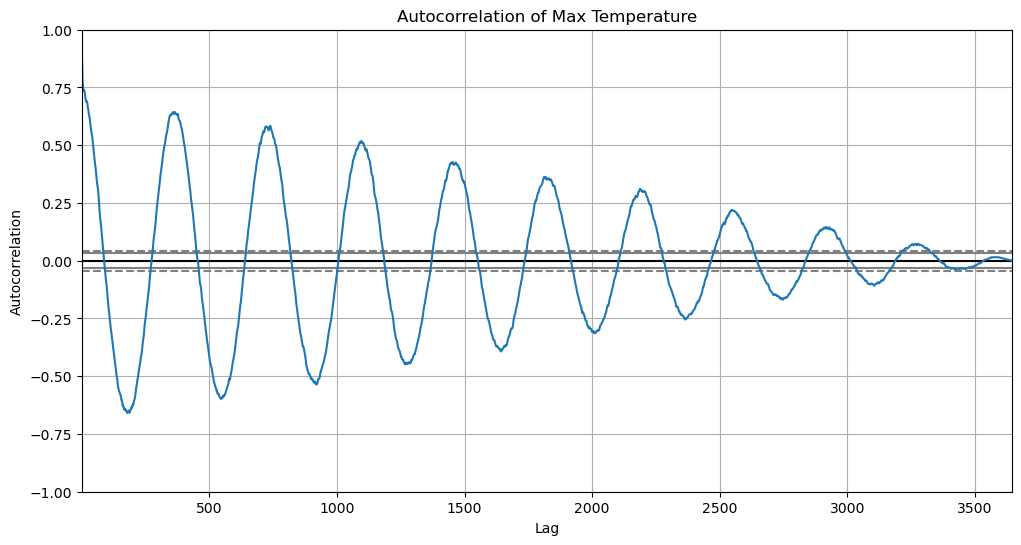

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_cleaned['TMAX'], model='additive', period=365)
decomposition.plot()
plt.show()

from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(12, 6))
autocorrelation_plot(data_cleaned['TMAX'])
plt.title('Autocorrelation of Max Temperature')
plt.show()

### Analyzing Cyclical Trends and Autocorrelation in Lisbon's Temperature Data

The comprehensive decomposition of Lisbon’s maximum temperature records (TMAX) over a decade elucidates the intricate patterns and anomalies within the dataset. The time series decomposition graphically disentangles the data into three principal elements: the overall trend, the seasonal oscillations, and the residual component. The trend graph captures a gradual evolution of temperatures, possibly reflecting a longer-term climatic progression or shift. The seasonal graph articulates the expected cyclical fluctuations, which resonate with Lisbon’s characteristic seasonal weather patterns. The residuals—what remains after the trend and seasonality have been considered—highlight the irregular or unexpected deviations that could be attributed to episodic or non-recurring events.

The autocorrelation graph provides a deeper insight into the temporal structure of the data by plotting the correlation of Lisbon’s temperature with its own past values (lags). The resulting waveform, with its crests and troughs at consistent intervals, underscores a robust seasonal influence that is mirrored across the years. Such regularity suggests that past temperatures can be indicative of future values, a trait that is particularly beneficial for predictive modeling.

Notably, the persistence of the autocorrelation over several lags, without an abrupt decrease, suggests that the seasonal component remains influential and does not diminish quickly over time. The autocorrelation coefficients largely lie within the confidence bounds, indicating that the temperature data is not a random walk and is thus likely to be stationary, an essential characteristic for many time series analytical methods.

Together, the decomposition and autocorrelation provide a multifaceted understanding of the temporal dynamics in Lisbon’s temperature data. These analyses are not just academic exercises; they have practical implications for forecasting models, climate trend analysis, and strategic planning in sectors such as energy and agriculture. They effectively capture the complex rhythm of temporal elements that shape Lisbon’s climate, forming a solid basis for future climatological studies and data-driven decision-making.

---

### 4. In-depth Statistical Analysis

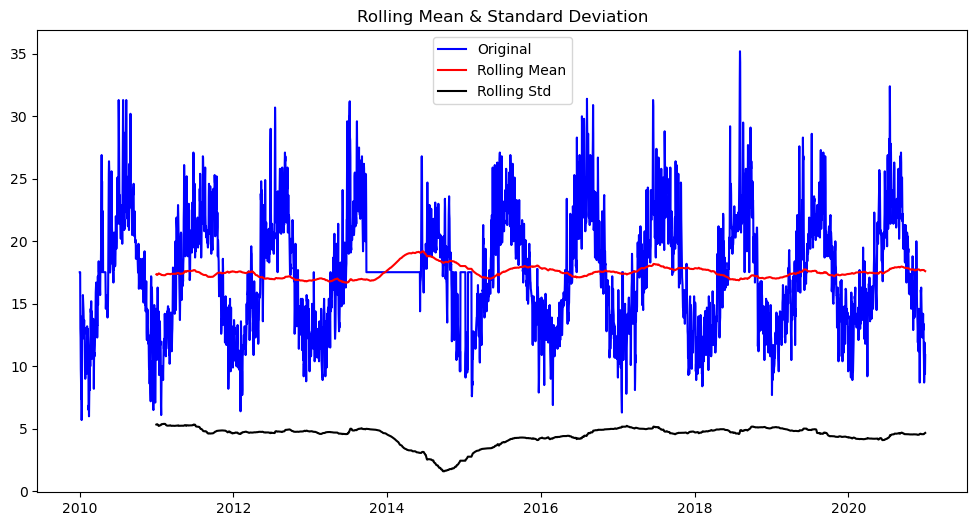

Results of Dickey-Fuller Test:
Test Statistic                   -4.086620
p-value                           0.001019
#Lags Used                       18.000000
Number of Observations Used    3990.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862265
Critical Value (10%)             -2.567156
dtype: float64
Mann-Whitney U Test Results:
{'Mann-Whitney Statistic': 1998327.0, 'P-Value': 0.8856372582959204}
Results of Mann-Kendall Trend Test:
Trend: no trend
p-value: 0.08725464796384763
Normalized Test Statistic: 1.7100607061003292


In [10]:
# Check if 'DATE' is a column and set it as an index if it is
if 'DATE' in data.columns:
    data.set_index('DATE', inplace=True)

# Ensure the index is a DatetimeIndex
data.index = pd.to_datetime(data.index)

# Fill NaN values in 'TAVG'
data['TAVG'].fillna(data['TAVG'].mean(), inplace=True)

# Function to test stationarity
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Test stationarity on 'TAVG'
test_stationarity(data['TAVG'])

# Split the data into two periods for the Mann-Whitney U Test
first_period = data['TAVG'][:'2014-12-31']
second_period = data['TAVG']['2015-01-01':]

# Apply Mann-Whitney U Test for trend
mann_whitney_stat, mann_whitney_p = mannwhitneyu(first_period, second_period)

# Output Mann-Whitney U test results
mann_whitney_test_result = {
    "Mann-Whitney Statistic": mann_whitney_stat,
    "P-Value": mann_whitney_p
}
print("Mann-Whitney U Test Results:")
print(mann_whitney_test_result)

# Function to perform Mann-Kendall Trend Test
def perform_mann_kendall_test(series):
    result = mk.original_test(series)
    print('Results of Mann-Kendall Trend Test:')
    print(f'Trend: {result.trend}')
    print(f'p-value: {result.p}')
    print(f'Normalized Test Statistic: {result.z}')

# Perform Mann-Kendall Trend Test on 'TAVG'
perform_mann_kendall_test(data['TAVG'])

### Climate Stability Analysis in Lisbon's Decadal Weather Data

#### Decadal Climate Stationarity in Lisbon:

The rolling analysis of Lisbon's decadal weather data, incorporating a rolling mean and standard deviation, alongside the Dickey-Fuller test results, suggests stationarity in the climate data. The Dickey-Fuller test yields a test statistic of -4.086620 and a p-value of 0.001019, strongly indicating the absence of unit roots, and hence, no persistent long-term trends in temperatures over the period from 2010 to 2020. This implies that, over the last decade, Lisbon's climate has been relatively stable, with the mean and variance not showing systematic changes over time.

#### Trend Examination:

Despite the absence of a unit root, the Mann-Kendall Trend Test provides a p-value of 0.087254, which does not denote a statistically significant trend within the data. The normalized test statistic of 1.7100607061003292 falls short of indicating a clear upward or downward trend in Lisbon's weather patterns over the past decade. This result aligns with the overall assessment of stability, although the closeness to the significance level suggests that longer-term observations may yet reveal emerging trends.

#### Climate Variability and Change Detection:

The Mann-Whitney U Test, yielding a p-value of 0.885637, reinforces the indication of stable weather patterns without significant shifts during the decade in question. This non-significant result indicates a uniform distribution across the two halves of the data, pointing towards an equilibrium in weather conditions throughout the period analyzed.

#### Implications and Future Directions:

The statistical analyses collectively paint a picture of climatic stability in Lisbon across the ten-year span. However, they also highlight the need for caution in interpreting these results as definitive evidence of an unchanging climate. Given the complexity of climate systems and the potential for long-term variability, it is critical to extend the study over a more extended period to capture any latent or developing trends. Advanced statistical techniques could also be employed to detect subtle shifts or non-linear trends in the data. Moreover, a focus on the frequency and intensity of extreme weather events would provide a more nuanced understanding of climate risks and variability.


In light of these findings, it is essential to continue monitoring Lisbon's climate with a long-term perspective, employing a comprehensive suite of analytical tools. This will ensure that any gradual changes in climate patterns are identified and addressed timely, supporting adaptive strategies for environmental and urban planning, agriculture, and public policy.

---